<a href="https://colab.research.google.com/github/rebeirima/Metootweet_classification/blob/main/finetuning_bertweet_metoo_tweet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning DistilBERT for Metoo Tweets Classification

# Importing Python Libraries <a id='section01'></a>


In [ ]:
# Data Analysis
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from tqdm.notebook import tqdm
tqdm.pandas()

#install 
!pip install emoji
!pip install contractions
!pip install transformers

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

#data preprocessing
import re
import string
import nltk
import emoji
import contractions
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#stop_words = set(stopwords.words('english')) - {'all'}

# Machine Learning
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler 
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from transformers import DistilBertTokenizer, DistilBertModel,BertForSequenceClassification, BertTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Pre-Processing the data <a id='section02'></a>


In [ ]:
train_data = pd.read_csv('final_tweets.csv')
print(f"Total Training Records : {len(train_data)}")

train_data = train_data.drop(['Country', 'TweetId'], axis=1)
train_data["Hate"] = train_data['Directed_Hate']+ train_data["Generalized_Hate"]
train_data = train_data.drop(['Directed_Hate', 'Generalized_Hate'], axis=1)

# move the 'Other' column to the end
train_data = train_data[['Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Support', 'Oppose', 'Hate', 'text']]
train_data.head()

Total Training Records : 5527


,Sarcasm,Allegation,Justification,Refutation,Support,Oppose,Hate,text
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,account suspended
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Domestic Violence Awareness Hasn’t Caught Up W...
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,It is 'high time' #MeToo named and shamed men ...
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,“There's this idea that persistence involves s...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Meredith’s #MeToo moment on #TheOffice


## Data Cleaning & Removing noise

- Lower case
- Remove extra space

In [ ]:
train_data["text"] = train_data["text"].str.lower()
train_data["text"] = train_data["text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

## Custom Preprocessing 

In [ ]:
# Regex to remove all Non-Alpha Numeric and space
# special_character_removal=re.compile(r'[^?!.,:a-z\d ]',re.IGNORECASE)
# regex to replace all numerics
replace_numbers=re.compile(r'\d+',re.IGNORECASE)
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

#played around with removing stop words and lemme the words
def clean_text(text):
    text = str(text)
    # Removes contraction
    text = contractions.fix(text)
    # Changes emojis to words
    text = emoji.demojize(text,  delimiters=(' ', ' '))
    # Removes 'RT' from tweet
    text = re.sub(r'RT[\s]+', '', text)
    # Remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Removes capitalization
    text = text.lower()
    # Removes urls & user mentions from tweet
    text = re.sub(r"http\S+|www\S+|https\S+|\@\w+", ' ', text, flags=re.MULTILINE)
    # Removes stopwords
    #tokens = [w for w in word_tokenize(text) if not w in stop_words]
    # Perfoms lemmatization on tokens
    #lemmatizer = WordNetLemmatizer()
    #lemma_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)]
    return text#" ".join(lemma_words)


In [ ]:
train_data["text"] = train_data["text"].progress_apply(clean_text)

  0%|          | 0/5527 [00:00<?, ?it/s]

In [ ]:
train_data.head()

,Sarcasm,Allegation,Justification,Refutation,Support,Oppose,Hate,text
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,account suspended
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,domestic violence awareness has not caught up ...
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,it is high time metoo named and shamed men in ...
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,there is this idea that persistence involves s...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,merediths metoo moment on theoffice


# Taking a Look at the Data <a id='section03'></a>

Looking at all the labels and how many tweets per label. We want to see how unbalanced the data is. 


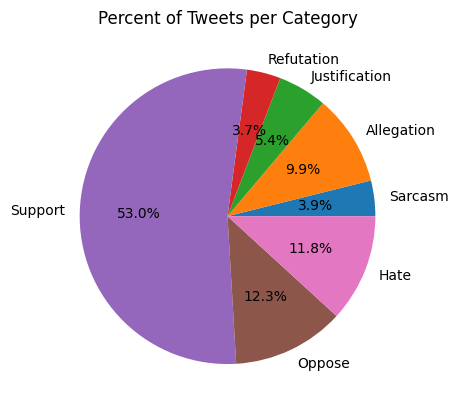

In [ ]:
category = ['Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Support', 'Oppose', 'Hate']
number_of_tweets = train_data.iloc[:, :7].sum()
fig, ax = plt.subplots()
ax.pie(number_of_tweets, labels=category, autopct='%1.1f%%')
ax.set_title('Percent of Tweets per Category')
plt.show()

# MLSMOTE <a id='section03'></a>

There is a high class imbalance in the dataset. We'll use SMOTE (Synthetic Minority Over-sampling Technique) to balance the class. 


In [ ]:
def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    """
    return ['Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Oppose', 'Hate']

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified
    
  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target

# Test-train Split <a id='section03'></a>


In [ ]:
# Train-Test Splitting
#tweet_labels = ['Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Support', 'Oppose', 'Hate']
X = train_data.drop(columns=['Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Support', 'Oppose', 'Hate'])
y = train_data.drop(columns=['text'])
#split when the columns are all in a list of labels 
#X = train_data.drop(columns=['label'])
#y = train_data['label']
#X = X.dropna(subset=["text"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)  

Tokenization and Vectorization for MLSMOTE

In [ ]:
tokenizer_bert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

#not sure if this is how to use the BERT tokenizer with this vectorizer - gotta check this later
# TF-IDF Vectorization on full training data
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer_bert)
X_tweets_tfidf = tfidf_vectorizer.fit_transform(X['text']) #this needs to be a df 
test_tweets_tfidf = tfidf_vectorizer.transform(y)
print(X_tweets_tfidf.shape, test_tweets_tfidf.shape)

X_tweets_tfidf = pd.DataFrame(X_tweets_tfidf.toarray())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5527, 2) (7, 2)


In [ ]:
X_sub, y_sub = get_minority_instace(X_tweets_tfidf, y)  # Getting minority samples of that datframe
X_res, y_res = MLSMOTE(X_sub, y_sub, 100)  # Applying MLSMOTE to augment the dataframe

    Sarcasm  Allegation  Justification  Refutation  Support  Oppose  Hate
0       0.0         0.0            1.0         0.0      1.0     0.0   0.0
1       0.0         1.0            0.0         0.0      1.0     0.0   0.0
2       0.0         0.0            1.0         0.0      1.0     0.0   0.0
3       0.0         0.0            1.0         0.0      1.0     0.0   0.0
4       0.0         1.0            1.0         0.0      0.0     0.0   1.0
..      ...         ...            ...         ...      ...     ...   ...
95      0.0         0.0            1.0         0.0      1.0     0.0   0.0
96      0.0         0.0            1.0         0.0      1.0     0.0   0.0
97      0.0         0.0            1.0         0.0      1.0     0.0   0.0
98      0.0         0.0            1.0         0.0      1.0     0.0   0.0
99      0.0         0.0            1.0         0.0      1.0     0.0   0.0

[1714 rows x 7 columns]


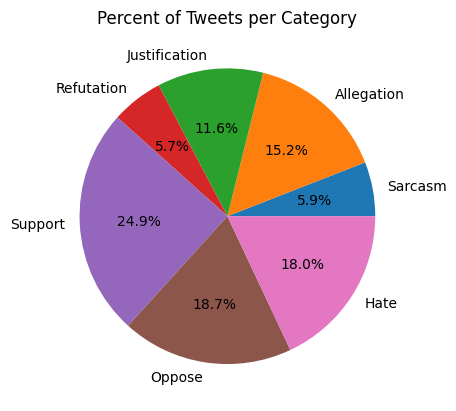

In [ ]:
print(y_res)
category = ['Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Support', 'Oppose', 'Hate']
number_of_tweets = y_res.iloc[:, :7].sum()
fig, ax = plt.subplots()
ax.pie(number_of_tweets, labels=category, autopct='%1.1f%%')
ax.set_title('Percent of Tweets per Category')
plt.show()

## Removing id column and preparing labels into the single list column

In [ ]:
# create new row 'labels'
y_res_label = y_res
y_res_label['labels'] = y_res.iloc[:, 0:7].values.tolist()

# delete the columns
y_res_label = y_res_label.drop(['Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Support', 'Oppose', 'Hate'], axis=1)

y_res = y_res.drop("labels", axis=1)
#y_res.head()

# create new row 'labels'
train_data_label = train_data
train_data_label['labels'] = train_data.iloc[:, 0:7].values.tolist()

# delete the columns
train_data_label = train_data_label.drop(['Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Support', 'Oppose', 'Hate'], axis=1)

train_data = train_data.drop("labels", axis=1)
#y_res.head()

#test-train split
old_train = train_data.copy()
train_data = train_data.sample(frac=0.8,random_state=200)
print(train_data)



      Sarcasm  Allegation  Justification  Refutation  Support  Oppose  Hate  \
139       0.0         0.0            0.0         0.0      0.0     0.0   0.0   
635       1.0         0.0            0.0         0.0      0.0     0.0   0.0   
3241      0.0         0.0            0.0         0.0      0.0     1.0   0.0   
2198      0.0         0.0            0.0         0.0      1.0     0.0   0.0   
1791      0.0         0.0            0.0         0.0      0.0     0.0   0.0   
...       ...         ...            ...         ...      ...     ...   ...   
5116      0.0         0.0            0.0         0.0      0.0     0.0   0.0   
5416      0.0         0.0            0.0         0.0      0.0     0.0   0.0   
5444      0.0         0.0            0.0         0.0      0.0     0.0   0.0   
2715      0.0         0.0            0.0         0.0      1.0     0.0   0.0   
1805      0.0         0.0            0.0         0.0      0.0     0.0   0.0   

                                                   

In [ ]:
test_data = old_train.drop(train_data.index)
print(test_data)

      Sarcasm  Allegation  Justification  Refutation  Support  Oppose  Hate  \
2         0.0         1.0            0.0         0.0      1.0     0.0   0.0   
17        0.0         0.0            1.0         0.0      1.0     0.0   0.0   
18        0.0         0.0            1.0         0.0      1.0     0.0   0.0   
37        1.0         1.0            1.0         0.0      1.0     0.0   0.0   
48        1.0         0.0            1.0         0.0      0.0     1.0   0.0   
...       ...         ...            ...         ...      ...     ...   ...   
5500      0.0         0.0            0.0         0.0      0.0     0.0   1.0   
5505      0.0         0.0            0.0         0.0      0.0     0.0   0.0   
5511      0.0         0.0            0.0         0.0      0.0     0.0   0.0   
5516      0.0         0.0            0.0         0.0      1.0     0.0   0.0   
5517      1.0         0.0            0.0         0.0      0.0     0.0   0.0   

                                                   

# Training Parameters <a id='section03'></a>

Defining some key variables that will be used later on in the training


In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 64
EPOCHS = 4
LEARNING_RATE = 1e-05
NUM_WORKERS = 2

# Preparing the Dataset and Dataloader <a id='section04'></a>


In [ ]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len: int, eval_mode: bool = False, truncation: bool = True):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.text = dataframe.text
        self.eval_mode = eval_mode 
        if self.eval_mode is False:
            self.targets = self.data.labels
        self.max_len = max_len
        self.truncation = truncation

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True, 
            truncation=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        output = {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }
                
        if self.eval_mode is False:
            output['targets'] = torch.tensor(self.targets.iloc[index], dtype=torch.float)
                
        return output

## Loading tokenizer and generating training set

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
training_set = MultiLabelDataset(train_data_label, tokenizer, MAX_LEN, truncation=True)

## Verify the data at index 0

In [ ]:
training_set[0]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'ids': tensor([ 101, 4070, 6731,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0, 

## Creating Dataloader

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': NUM_WORKERS
                }
training_loader = DataLoader(training_set, **train_params)

<a id='section05'></a>
# Neural Network for Fine Tuning


In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
        
class DistilBERTClass(torch.nn.Module):
    
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output


## Loading Neural Network model

In [ ]:
model = DistilBERTClass()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 #('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

## Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

<a id='section06'></a>
# Fine Tuning the Model


In [ ]:
def train(epoch):
    
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%20==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Epoch: 0, Loss:  0.7118311524391174
Epoch: 0, Loss:  0.4571000039577484
Epoch: 0, Loss:  0.3501068651676178
Epoch: 0, Loss:  0.3069234788417816
Epoch: 0, Loss:  0.27558767795562744


0it [00:00, ?it/s]

Epoch: 1, Loss:  0.28420576453208923
Epoch: 1, Loss:  0.2922455370426178
Epoch: 1, Loss:  0.2752102315425873
Epoch: 1, Loss:  0.32646459341049194
Epoch: 1, Loss:  0.25158658623695374


0it [00:00, ?it/s]

Epoch: 2, Loss:  0.30171188712120056
Epoch: 2, Loss:  0.269654244184494
Epoch: 2, Loss:  0.268957257270813
Epoch: 2, Loss:  0.3025287091732025
Epoch: 2, Loss:  0.27953600883483887


0it [00:00, ?it/s]

Epoch: 3, Loss:  0.2675478160381317
Epoch: 3, Loss:  0.30121469497680664
Epoch: 3, Loss:  0.3169005513191223
Epoch: 3, Loss:  0.3211076259613037
Epoch: 3, Loss:  0.32761865854263306


# Generate Submissions.csv <a id='section07'></a>

In [ ]:
# create new row 'labels'
test_data['labels'] = test_data.iloc[:, 0:7].values.tolist()
# delete the columns
test_data = test_data.drop(['Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Support', 'Oppose', 'Hate'], axis=1)

## Data Cleaning

In [ ]:
test_data["text"] = test_data["text"].str.lower()
test_data["text"] = test_data["text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

In [ ]:
test_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN, eval_mode = True)
testing_params = {'batch_size': TRAIN_BATCH_SIZE,
               'shuffle': False,
               'num_workers': 2
                }
test_loader = DataLoader(test_set, **testing_params)

In [ ]:
all_test_pred = []

def test(epoch):
    model.eval()
    
    with torch.inference_mode():
    
        for _, data in tqdm(enumerate(test_loader, 0)):


            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            outputs = model(ids, mask, token_type_ids)
            probas = torch.sigmoid(outputs)

            all_test_pred.append(probas)
    return probas

In [ ]:
probas = test(model)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
all_test_pred = torch.cat(all_test_pred)

In [ ]:
submit_df = test_data.copy()
submit_df.drop("text", inplace=True, axis=1)

In [ ]:
label_columns = ["Sarcasm", "Allegation", "Justification", "Refutation", "Support", "Oppose", "Hate"]


In [ ]:
for i,name in enumerate(label_columns):

    submit_df[name] = all_test_pred[:, i].cpu()
    submit_df.head()

In [ ]:
submit_df.to_csv('submission2.csv', index=False)
print(submit_df)
#print(test_data.head())

                                   labels   Sarcasm  Allegation  \
2     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]  0.506356    0.455929   
17    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]  0.501707    0.467162   
18    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]  0.480380    0.448280   
37    [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]  0.472957    0.474369   
48    [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]  0.486335    0.468456   
...                                   ...       ...         ...   
5500  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]  0.488687    0.451214   
5505  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  0.477448    0.495468   
5511  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  0.492268    0.466732   
5516  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]  0.493927    0.480515   
5517  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  0.498400    0.464189   

      Justification  Refutation   Support    Oppose      Hate  
2          0.478756    0.503277  0.506784  0.510053  0.479494  
17         0.482748    0.518499  0.500014  0.521222  0.472999  
18 

In [ ]:

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support


# Compute confusion matrix for each predicted label
# Define a list of labels
labels = ['Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Support', 'Oppose', 'Hate']

# unpack values from list of lists
col_1, col_2, col_3, col_4, col_5, col_6, col_7 = zip(*submit_df['labels'])

# convert tuples to lists
col_1, col_2, col_3, col_4, col_5, col_6, col_7 = list(col_1), list(col_2), list(col_3), list(col_4), list(col_5), list(col_6), list(col_7)
loop_list = [col_1,col_2, col_3, col_4, col_5, col_6, col_7]
count = 0

# Convert the labels into a binary array representation
mlb = MultiLabelBinarizer()


# Loop through each label
for label in labels:
    y_true = loop_list[count] 
    y_pred = submit_df[label].tolist() # Extract the predicted label
    for i in range(len(y_pred)):
      if y_pred[i] < 0.5:
          y_pred[i] = 0
      else:
          y_pred[i] = 1
    cm = confusion_matrix(y_true, y_pred) # Calculate the confusion matrix
    print(f"Confusion matrix for {label}:")
    print(cm)
    score = precision_recall_fscore_support(y_true, y_pred, average='macro')
    print(f"score for {label}:")
    print(score)
    count += 1




Confusion matrix for Sarcasm:
[[858 206]
 [ 31  10]]
score for Sarcasm:
(0.5057128275632213, 0.5251467082339996, 0.47823462258004745, None)
Confusion matrix for Allegation:
[[1023    3]
 [  78    1]]
score for Allegation:
(0.5895776566757494, 0.5048671256199571, 0.49300729009125355, None)
Confusion matrix for Justification:
[[926 134]
 [ 41   4]]
score for Justification:
(0.4932931672736538, 0.48123689727463315, 0.4786906812673714, None)
Confusion matrix for Refutation:
[[193 877]
 [  6  29]]
score for Refutation:
(0.5009290381266154, 0.5044726301735648, 0.18290653689844227, None)
Confusion matrix for Support:
[[292 344]
 [198 271]]
score for Support:
(0.5182843869255019, 0.518472328385029, 0.5093250444049733, None)
Confusion matrix for Oppose:
[[ 13 987]
 [  4 101]]
score for Oppose:
(0.4287683823529411, 0.48745238095238097, 0.09744321389686314, None)
Confusion matrix for Hate:
[[1002    8]
 [  95    0]]
score for Hate:
(0.4567000911577028, 0.49603960396039604, 0.47555766492643564, No